# 1. Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, confusion_matrix

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 10,5

# 2. Import datasets

In [4]:
df = pd.read_csv("../inputs/1_Bins.csv")
df.shape

(9578, 13)

# 3. Model - initial

In [5]:
y = df['Def']
x = df.drop(['delinq_2yrs_bin','int_rate_bin','Def'], axis=1)

In [6]:
x = sm.add_constant(x)
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.412925
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    Def   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9567
Method:                           MLE   Df Model:                           10
Date:                Fri, 27 Oct 2023   Pseudo R-squ.:                 0.06102
Time:                        01:14:51   Log-Likelihood:                -3955.0
converged:                       True   LL-Null:                       -4212.0
Covariance Type:            nonrobust   LLR p-value:                4.395e-104
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -8.3008      0.513    -16.188      0.000      -9.306      -7.

In [7]:
pred_values = log_reg.predict(x)
pred_values = pd.DataFrame(pred_values)[0]
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))

AUROC: 0.674


In [8]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.348


# 4. Model - final

In [9]:
y = df['Def']
x = df[['purpose_bin','credit_policy_bin','inq_last_6mths_bin','fico_bin']]

In [10]:
x = sm.add_constant(x)
log_reg = sm.Logit(y, x).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.416333
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    Def   No. Observations:                 9578
Model:                          Logit   Df Residuals:                     9573
Method:                           MLE   Df Model:                            4
Date:                Fri, 27 Oct 2023   Pseudo R-squ.:                 0.05327
Time:                        01:14:51   Log-Likelihood:                -3987.6
converged:                       True   LL-Null:                       -4212.0
Covariance Type:            nonrobust   LLR p-value:                 8.052e-96
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.6978      0.165    -28.401      0.000      -5.022      -4.374
purpo

In [11]:
pred_values = log_reg.predict(x)
pred_values = pd.DataFrame(pred_values)[0]
print('AUROC:',np.round(roc_auc_score(y, pred_values), 3))

AUROC: 0.665


In [12]:
auroc = roc_auc_score(y, pred_values)
gini = 2 * auroc - 1
print('Gini:',np.round(gini, 3))

Gini: 0.331


# 5. Confusion Matrix

In [13]:
train_dict = {'actuals':y, 'predicted':pred_values}
test_calc = pd.DataFrame(train_dict)

max f:  0.15


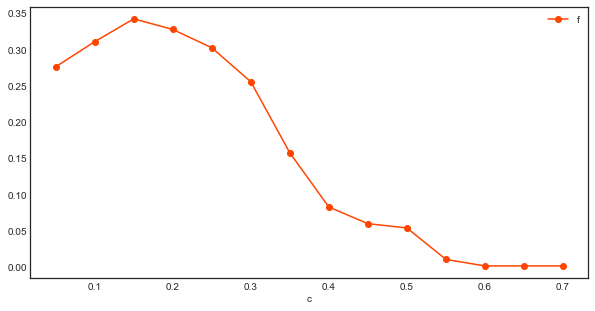

In [14]:
c = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
f = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
i = 0
for j in c:
    def flag(x):
        if x > j: return 1
        else: return 0
    test_calc['flag'] = test_calc['predicted'].apply(flag)
    df_table = confusion_matrix(test_calc['actuals'],test_calc['flag'])
    p = df_table[1,1] / (df_table[1,1] + df_table[0,1])
    r = df_table[1,1] / (df_table[1,1] + df_table[1,0])
    f[i] = (2 * p * r) / (p + r)
    i = i+1

df_decision = pd.concat([pd.DataFrame(c),pd.DataFrame(f)],axis=1)
df_decision.columns = ['c','f']
f_max = df_decision[df_decision['f']==df_decision['f'].max()].head(1)
max_f = float(f_max['c'])

df_decision.plot(x='c',y='f',marker="o", color='orangered')
print ("max f: ",max_f)

# 6. Accuracy and F1

In [15]:
def cut_off (x):
    if x > 0.15: return 1
    else: return 0
test_calc['flag'] = test_calc['predicted'].apply(cut_off)
print(confusion_matrix(test_calc['actuals'],test_calc['flag']))

[[5579 2466]
 [ 708  825]]


In [16]:
c = confusion_matrix(test_calc['actuals'],test_calc['flag'])
print('Accuracy:',np.round((c[0][0] + c[1][1]) / c.sum(),3))

Accuracy: 0.669


In [17]:
p = c[1][1] / (c[1][1] + c[0][1])
r = c[1][1] / (c[1][1] + c[1][0])
print('F1 Score:',np.round((2 * p * r) / (p + r),3))

F1 Score: 0.342


# 7. KS

In [18]:
test_calc = test_calc.sort_values('predicted', ascending=False)
test_calc['def'] = test_calc['predicted']
test_calc['non_def'] = 1-test_calc['predicted']
test_calc['bins'] = pd.qcut(test_calc['non_def'], 5, labels=[0,1,2,3,4])

test_calc = test_calc.groupby('bins').agg({'def':'sum', 'non_def':'sum'}).reset_index()
test_calc = test_calc.sort_values('bins')
test_calc['def'] = test_calc['def'] / test_calc['def'].sum()
test_calc['non_def'] = test_calc['non_def'] / test_calc['non_def'].sum()

test_calc['def'] = test_calc['def'].cumsum()
test_calc['non_def'] = test_calc['non_def'].cumsum()
test_calc['KS'] = test_calc['def'] - test_calc['non_def']
print(test_calc)
print('\n KS:',np.round(test_calc['KS'].max(),3))

  bins       def   non_def            KS
0    0  0.379048  0.168666  2.103818e-01
1    1  0.705812  0.508513  1.972983e-01
2    2  0.842130  0.690493  1.516367e-01
3    3  0.907985  0.799261  1.087237e-01
4    4  1.000000  1.000000  2.220446e-16

 KS: 0.21


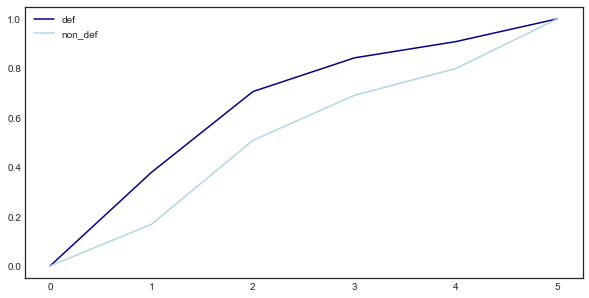

In [19]:
train_dict = {'bins':[-1],'def':[0],'non_def':[0],'KS':[0]}
train_dict = pd.DataFrame.from_dict(train_dict)
test_calc = pd.concat([train_dict,test_calc]).reset_index()

plt.plot(test_calc['def'], color='darkblue', label='def')
plt.plot(test_calc['non_def'], color='lightblue', label='non_def')
plt.legend();